# Contract analytics for Cheese Grotto

In [21]:
import numpy as np
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
from pandasql import sqldf #for manipulating DataFrames with SQL style queries
#Write file to machine to work with offline
import json

#ALL BELOW to export results of API request to local file
# Make it work for Python 2+3 and with Unicode
import io
try:
    to_unicode = unicode
except NameError:
    to_unicode = str

# Instagram graph api

In [10]:
#generated each session by the graph api explorer
user_access_token = ''

In [11]:
#Get the user's pages
#For better security these must all be derived after a new user access token is created by the person logged 
#into the fb business account
user_pages = f'https://graph.facebook.com/v4.0/me/accounts?access_token={user_access_token}'
response = requests.get(user_pages)
page_id = json.loads(response.text)['data'][0]['id']

#Get the page's instagram business account id
insta_biz_account = f'https://graph.facebook.com/v4.0/{page_id}?fields=instagram_business_account&access_token={user_access_token}'
response = requests.get(insta_biz_account)
insta_id = json.loads(response.text)['instagram_business_account']['id']

In [13]:
#Get the Instagram Business Account's Media Objects
media_objects = f'https://graph.facebook.com/v4.0/{insta_id}/media?access_token={user_access_token}&limit=2000'
response = requests.get(media_objects)
media_object_ids = [object['id'] for object in json.loads(response.text)['data']]

In [14]:
len(json.loads(response.text)['data'])

1317

In [ ]:
# media_objects = []
# for obj_id in media_object_ids:
#     media_objects.append(requests.get(f'https://graph.facebook.com/v4.0/{obj_id}?fields=comments,like_count,timestamp&access_token={user_access_token}').text)
#     time.sleep(1.5)

In [15]:
media_objects_all = []
for obj_id in media_object_ids:
    media_objects_all.append(requests.get(f'https://graph.facebook.com/v4.0/{obj_id}?fields=caption,comments,comments_count,media_type,media_url,like_count,timestamp&access_token={user_access_token}').text)
    time.sleep(1.25)
    if len(media_objects_all) // 100 == 0:
        print(len(media_objects_all))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [16]:
len(media_objects_all)

1317

In [19]:
media_objects_all[1000]

'{"caption":"It\'s a #tbt #ontheblog today. Looking back on October and all the things that brought us inspiration: from cheesy politics in Russia, to the ultimate recipe for Queso Dip, to sleek kitchenware design by \\u0040blackblumdesign, to Swiss cheese making adventures by \\u0040culturecheese...check it out! #linkinbio \\nPhoto by \\u0040designmilk","comments":{"data":[{"timestamp":"2015-10-29T15:25:09+0000","text":"Swoon sink \\ud83d\\ude0d","id":"17844630712041130"},{"timestamp":"2015-10-29T14:13:00+0000","text":"I want that sink!","id":"17844629953041130"},{"timestamp":"2015-10-29T13:50:04+0000","text":"#kitchendesign #kitchenwares #cheeselove #cgvision #cheesepolitics","id":"17844629635041130"}]},"comments_count":3,"media_type":"IMAGE","media_url":"https:\\/\\/scontent.xx.fbcdn.net\\/v\\/t51.2885-15\\/12063084_1650784255203302_1983467350_n.jpg?_nc_cat=104&_nc_oc=AQkJSczyX1KwJuYgIcQrlIY1QG5Yjvquz8gbI6GBPgmXOBaK13lIgInRf1t3KNNfB9M&_nc_ht=scontent.xx&oh=e5b469ec1661d1738ec0f60251

In [ ]:
#SEe for more fields: https://developers.facebook.com/docs/instagram-api/reference/media/

requests.get(f'https://graph.facebook.com/v4.0/{media_object_ids[0]}?fields=caption,comments,comments_count,media_type,media_url,like_count,timestamp&access_token={user_access_token}').text
#/?fields={fields}

In [ ]:
len(media_objects)

In [ ]:
media_objects[1311]

In [24]:
# Write JSON file
with io.open('media_objects.json', 'w', encoding='utf8') as outfile:
    str_ = json.dumps(media_objects_all,
                      indent=4, sort_keys=True,
                      separators=(',', ': '), ensure_ascii=False)
    outfile.write(to_unicode(str_))

In [25]:
# Read JSON file
with open('media_objects.json') as data_file:
    media_objects_json = json.load(data_file)

In [45]:
media_objects_json[-1]

'{"caption":"\\u0040CheeseGrotto on a crisp fall eve, in a Manhattan garden. #cheese #cheesegrotto #elegance  http:\\/\\/kck.st\\/1qnfB7U","comments":{"data":[{"timestamp":"2014-11-11T00:20:51+0000","text":"\\u0040foodandwine","id":"17850626032041130"}]},"comments_count":1,"media_type":"IMAGE","media_url":"https:\\/\\/scontent.xx.fbcdn.net\\/v\\/t51.2885-15\\/10756015_338589502980226_1503532671_n.jpg?_nc_cat=111&_nc_oc=AQmJNXrHGwU811W13pNff1sPv-zF-9jAn11LGwPCcU0W28fLwOyuAKsW9kf9VHEqJxc&_nc_ht=scontent.xx&oh=19259663d526720bc1519e5c87b430f3&oe=5E194277","like_count":8,"timestamp":"2014-11-10T22:47:02+0000","id":"17841922594041130"}'

In [48]:
media_objects_dicts = [json.loads(obj) for obj in media_objects_json]
columns = (list(media_objects_dicts[0].keys()))
data = {col: [obj[col] if col in list(obj.keys()) else None for obj in media_objects_dicts] for col in columns}

In [46]:
#Only one thing has no caption?
[obj  for obj in media_objects_dicts if not 'caption' in list(obj.keys())]

[{'comments_count': 0,
  'media_type': 'IMAGE',
  'media_url': 'https://scontent.xx.fbcdn.net/v/t51.2885-15/12976473_601177126725781_1633422619_n.jpg?_nc_cat=106&_nc_oc=AQnPbzGmSWt141M264fr38Cg9geI8UyoFfHO1pGSum0ojfOlm_8tdRKKFT7AouDudZ4&_nc_ht=scontent.xx&oh=5bcc14f7b429450d22e4f06445d1554d&oe=5E209D4B',
  'like_count': 21,
  'timestamp': '2016-04-23T21:52:11+0000',
  'id': '17846983060128875'}]

In [61]:
#build pandas data frame to look at data
df = pd.DataFrame(data)
df.set_index(pd.to_datetime(df['timestamp']), inplace = True)
df.drop(['timestamp'], axis = 1, inplace = True)
df.sort_index(axis = 0, ascending = True, inplace = True)

In [72]:
df.head()

,caption,comments,comments_count,media_type,media_url,like_count,id
timestamp,,,,,,,
2014-11-10 22:47:02,"@CheeseGrotto on a crisp fall eve, in a Manhat...",{'data': [{'timestamp': '2014-11-11T00:20:51+0...,1,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/10...,8,17841922594041130
2014-11-10 22:52:51,"Our #cheesesafe is a beautiful, simple gift fo...",None,0,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/10...,6,17841735106041130
2014-11-10 23:04:47,This rich bloomy rind cheese was made in a @Ch...,{'data': [{'timestamp': '2016-09-09T03:22:34+0...,2,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/10...,10,17843576941041130
2014-11-10 23:19:00,Our #cheesesafe with an awesome leather handle...,None,0,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/10...,8,17841735103041130
2014-11-10 23:43:33,The goats want to know.....where's the @Cheese...,None,0,IMAGE,https://scontent.xx.fbcdn.net/v/t51.2885-15/10...,1,17843576947041130


Text(0.5,1,'Number of likes on posts over time')

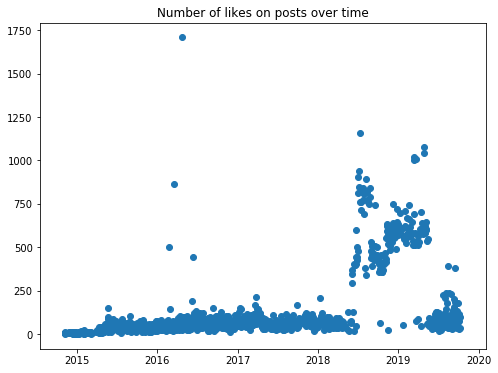

In [77]:
fig = plt.figure(figsize = (8,6))
plt.scatter(df.index, df['like_count'])
plt.title('Number of likes on posts over time')

Text(0.5,1,'Number of comments on posts over time')

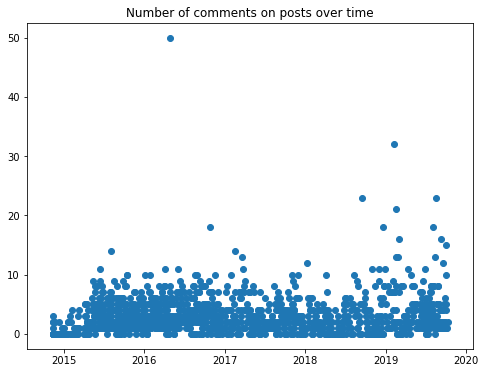

In [78]:
fig = plt.figure(figsize = (8,6))
plt.scatter(df.index, df['comments_count'])
plt.title('Number of comments on posts over time')

In [ ]:
df[]